Model loaded successfully!
Scaler loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Predicted LTP for the next day: 648.70
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14m

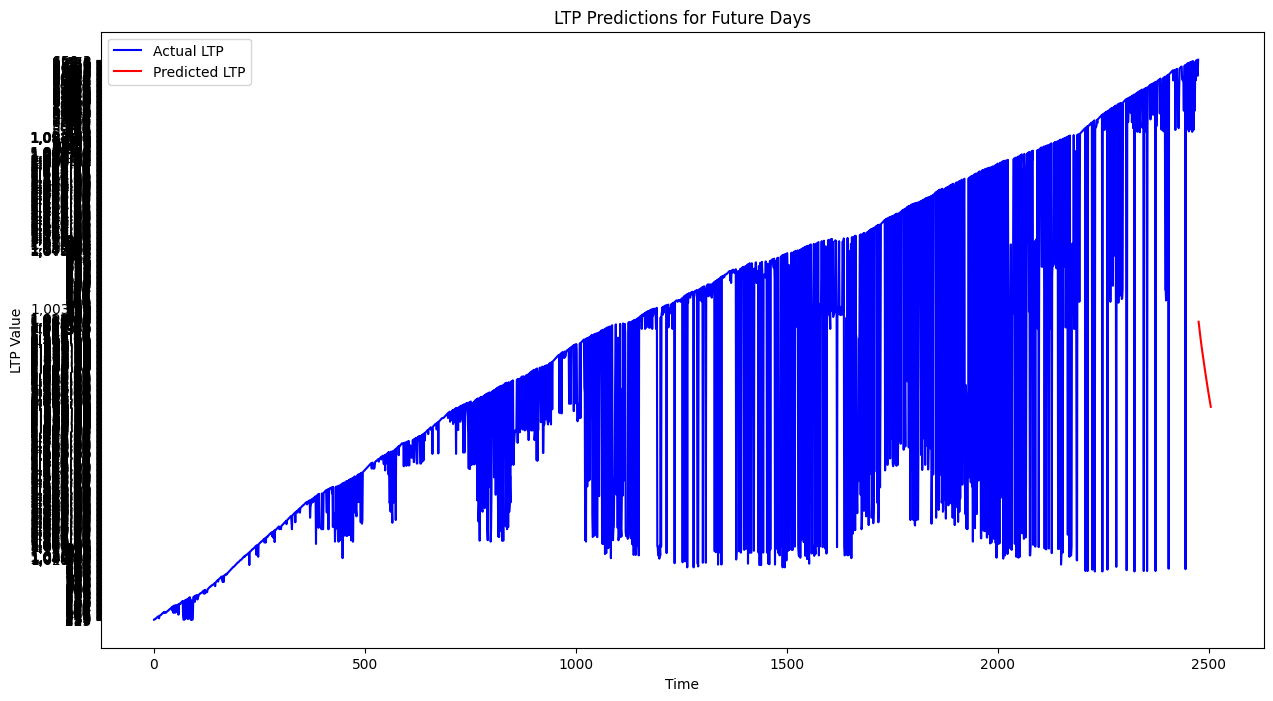

In [5]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

class StockPredictor:
    def __init__(self, model_path, scaler_path=None):
        """
        Initialize the StockPredictor with a saved model and optional scaler.

        Args:
            model_path (str): Path to the saved Keras model.
            scaler_path (str): Path to the saved MinMaxScaler (optional).
        """
        self.model = load_model(model_path)
        print("Model loaded successfully!")
        self.scaler = None
        
        if scaler_path:
            self.load_scaler(scaler_path)

    def load_scaler(self, scaler_path):
        """
        Load the saved MinMaxScaler.
        
        Args:
            scaler_path (str): Path to the scaler file (Pickle format).
        """
        import joblib  # Used for saving/loading scalers
        self.scaler = joblib.load(scaler_path)
        print("Scaler loaded successfully!")

    def preprocess_data(self, data, time_steps=60):
        """
        Preprocess the input data for prediction.
        
        Args:
            data (pd.Series, pd.DataFrame, or np.ndarray): The LTP values to preprocess.
            time_steps (int): Number of time steps to look back.
        
        Returns:
            np.ndarray: Scaled and reshaped data.
        """
        # Clean the data by removing commas and converting to float
        if isinstance(data, pd.Series):
            data = data.replace({',': ''}, regex=True)  # Remove commas
            data = data.astype(float)  # Convert to float
        
        # Convert to NumPy array if input is a Pandas DataFrame or Series
        if isinstance(data, (pd.Series, pd.DataFrame)):
            data = data.to_numpy()  # Convert to NumPy array
    
        data = data.reshape(-1, 1)  # Reshape to (n_samples, 1)
    
        if self.scaler:
            data = self.scaler.transform(data)  # Scale if scaler is provided
    
        # Prepare the last `time_steps` data points
        data = data[-time_steps:]
        return data.reshape(1, time_steps, 1)


    def predict_next(self, input_data):
        """
        Predict the next day's LTP using the model.
        
        Args:
            input_data (np.ndarray): Preprocessed input data.
        
        Returns:
            float: Predicted value in original scale.
        """
        prediction = self.model.predict(input_data)
        
        if self.scaler:
            prediction = self.scaler.inverse_transform(prediction)
        
        return prediction[0][0]

    def predict_future(self, input_data, n_days=30):
        """
        Predict LTP values for multiple future days.
        
        Args:
            input_data (np.ndarray): Preprocessed input data.
            n_days (int): Number of future days to predict.
        
        Returns:
            np.ndarray: Array of predicted values in original scale.
        """
        temp_input = list(input_data.flatten())
        predictions = []
        
        for _ in range(n_days):
            next_pred = self.model.predict(np.array(temp_input[-60:]).reshape(1, 60, 1))
            predictions.append(next_pred[0][0])
            temp_input.append(next_pred[0][0])
        
        if self.scaler:
            predictions = self.scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
        
        return predictions.flatten()

    def plot_predictions(self, actual_data, future_predictions):
        """
        Plot actual data and future predictions.
        
        Args:
            actual_data (np.ndarray): Array of actual LTP values.
            future_predictions (np.ndarray): Array of predicted LTP values.
        """
        plt.figure(figsize=(15, 8))
        plt.plot(actual_data, label='Actual LTP', color='blue')
        plt.plot(
            range(len(actual_data), len(actual_data) + len(future_predictions)),
            future_predictions, label='Predicted LTP', color='red'
        )
        plt.xlabel('Time')
        plt.ylabel('LTP Value')
        plt.title('LTP Predictions for Future Days')
        plt.legend()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Load data for prediction
    csv_file = "NULBdata.csv"  # Replace with your dataset
    model_path = "stock_lstm_model2.h5"  # Path to saved model
    scaler_path = "scaler.pkl"  # Path to saved MinMaxScaler (optional)

    # Load dataset
    data = pd.read_csv(csv_file)
    ltp_values = data['Ltp']  # Replace with the column name for LTP

    # Initialize StockPredictor
    predictor = StockPredictor(model_path, scaler_path)

    # Preprocess the data
    preprocessed_data = predictor.preprocess_data(ltp_values)

    # Predict the next day's LTP
    next_day_prediction = predictor.predict_next(preprocessed_data)
    print(f"Predicted LTP for the next day: {next_day_prediction:.2f}")

    # Predict future LTP values
    future_days = 30
    future_predictions = predictor.predict_future(preprocessed_data, n_days=future_days)
    print(f"Future Predictions for {future_days} Days:")
    print(future_predictions)

    # Plot the predictions
    predictor.plot_predictions(ltp_values, future_predictions)
